In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_csv("Volve P-12_DatesCorrected.csv", index_col = 0, parse_dates = True) #time-series data
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3291 entries, 2007-01-09 to 2016-01-12
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   onstreaminject_HRS              3291 non-null   float64
 1   BORE_WI_VOL                     3291 non-null   int64  
 2   ON_STREAM_HRS                   3291 non-null   float64
 3   AVG_DOWNHOLE_PRESSURE           3291 non-null   float64
 4   AVG_DOWNHOLE_TEMPERATURE        3291 non-null   float64
 5   AVG_DP_TUBING                   3291 non-null   float64
 6   AVG_ANNULUS_PRESS               3291 non-null   float64
 7   AVG_CHOKE_SIZE_P in percentage  3291 non-null   float64
 8   AVG_WHP_P                       3291 non-null   float64
 9   AVG_WHT_P                       3291 non-null   float64
 10  DP_CHOKE_SIZE                   3291 non-null   float64
 11  BORE_OIL_VOL                    3291 non-null   float64
 12  BORE_GAS_VOL    

onstreaminject_HRS                0
BORE_WI_VOL                       0
ON_STREAM_HRS                     0
AVG_DOWNHOLE_PRESSURE             0
AVG_DOWNHOLE_TEMPERATURE          0
AVG_DP_TUBING                     0
AVG_ANNULUS_PRESS                 0
AVG_CHOKE_SIZE_P in percentage    0
AVG_WHP_P                         0
AVG_WHT_P                         0
DP_CHOKE_SIZE                     0
BORE_OIL_VOL                      0
BORE_GAS_VOL                      0
BORE_WAT_VOL                      0
dtype: int64

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

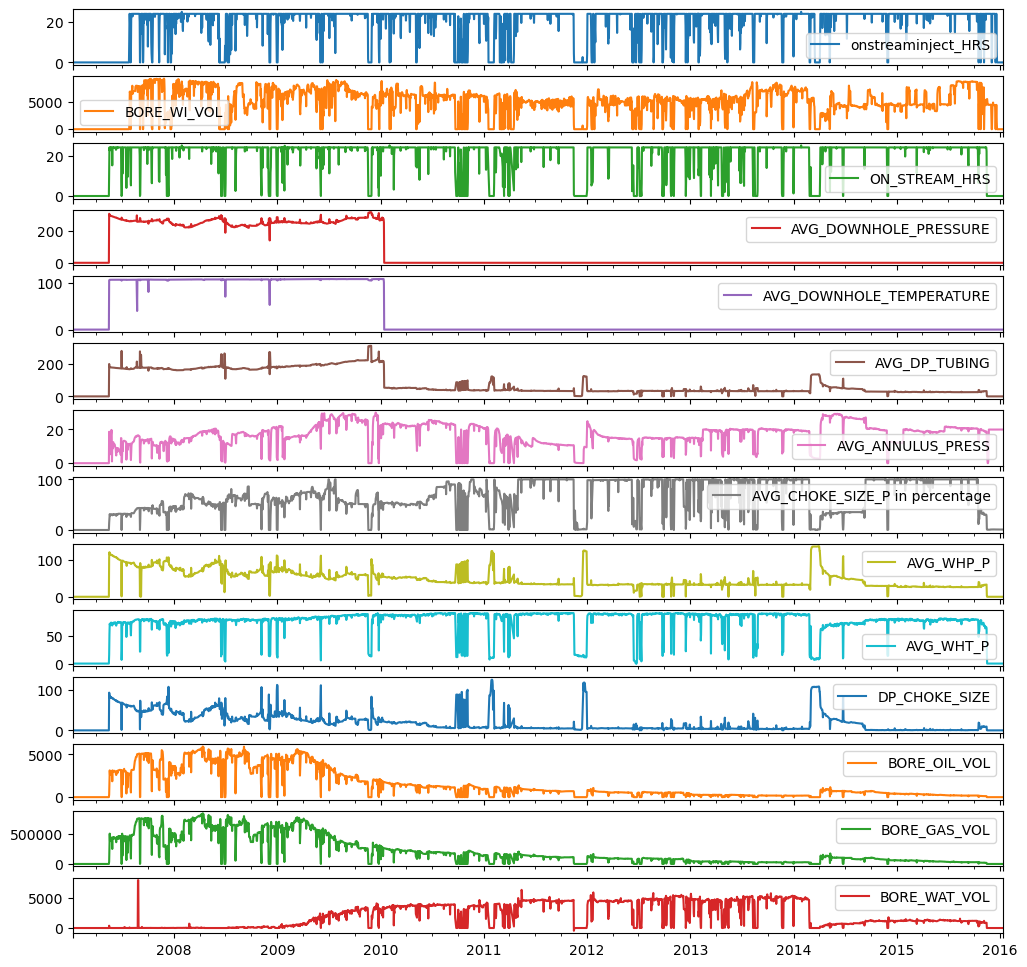

In [5]:
#y = bore_oil_vol --> this is the label we will be predicting
df.plot(subplots = True, figsize=(12,12))

In [6]:
output_col = "BORE_OIL_VOL"

<Axes: >

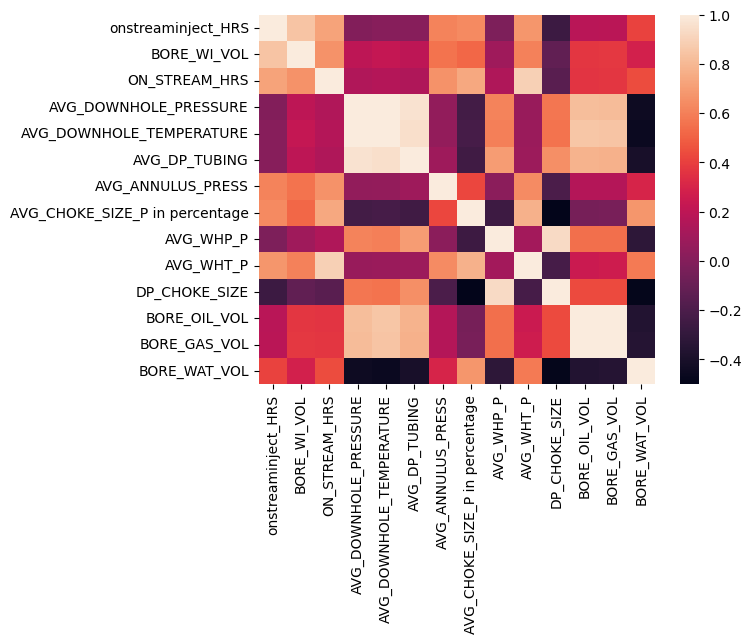

In [9]:
#assuming that this is a linear regression and one of the things to check is that the multiple correality doesn't exist
sns.heatmap(df.corr())
#this heatmap shows that there are some features which are highly correlated which causes redundancy so we remove one of them. Also we remove features
#which are highly correlated with the output_col to avoid data leakage

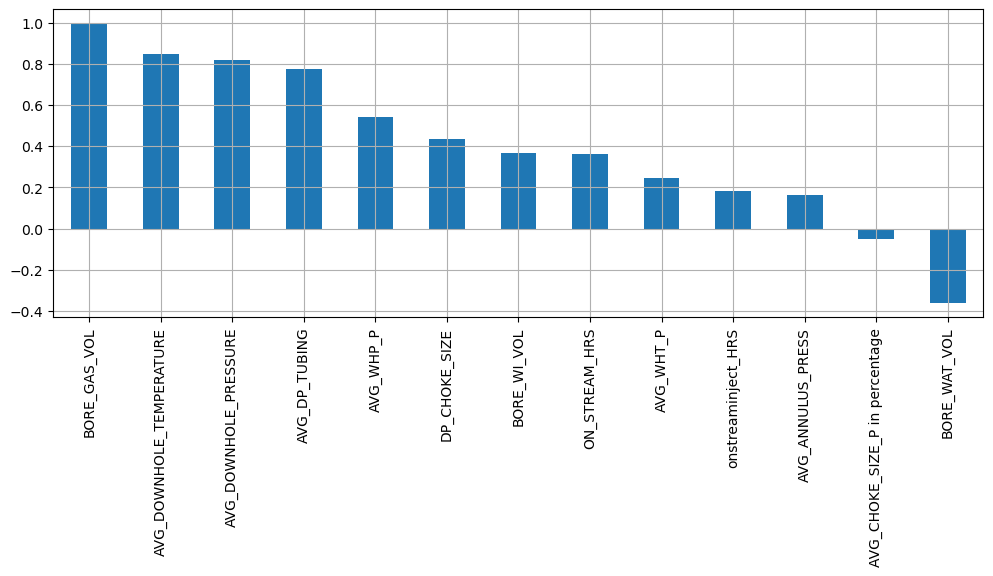

In [17]:
#focusing on each features correlation with output feature
df.corr()[output_col].sort_values(ascending=False)[1:].plot(kind="bar",figsize=(12,4), grid=True)

In [24]:
corr_df = pd.DataFrame(df.corr()[output_col].sort_values(ascending=False)[1:])
corr_df.columns = ["Corr"]
corr_df

,Corr
BORE_GAS_VOL,0.998661
AVG_DOWNHOLE_TEMPERATURE,0.850241
AVG_DOWNHOLE_PRESSURE,0.819920
AVG_DP_TUBING,0.778941
AVG_WHP_P,0.544204
DP_CHOKE_SIZE,0.434375
BORE_WI_VOL,0.368739
ON_STREAM_HRS,0.361124
AVG_WHT_P,0.245750
onstreaminject_HRS,0.182405


In [26]:
#since the bore_gas_vol is almost perfectly correlated with bore_oil_vol we will exclude this feature because when oil is produced gas is also produced.
input_col = corr_df[(abs(corr_df["Corr"])>0.2) & (corr_df["Corr"]<0.90)].index
input_col

Index(['AVG_DOWNHOLE_TEMPERATURE', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DP_TUBING',
       'AVG_WHP_P', 'DP_CHOKE_SIZE', 'BORE_WI_VOL', 'ON_STREAM_HRS',
       'AVG_WHT_P', 'BORE_WAT_VOL'],
      dtype='object')

Linear Regression Model

In [29]:
x = df[input_col]
y = df[output_col]
train_length = 3000 #days, there are 3291 rows from which 3000 is train and 291 is test data
x_train, y_train = x.iloc[:train_length, :], y[:train_length]
x_test, y_test = x.iloc[train_length:], y[train_length:]


In [30]:
#scaling the data to fit a common range
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler() --> this brings down everything to 0-1 range
scaler = StandardScaler() #--> this brings it down to a standard distribution range with center as 0 and standard deviation as 1
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
lm = LinearRegression()

In [33]:
lm.fit(x_train_scaled, y_train)

LinearRegression()

In [34]:
yp_train = lm.predict(x_train_scaled)

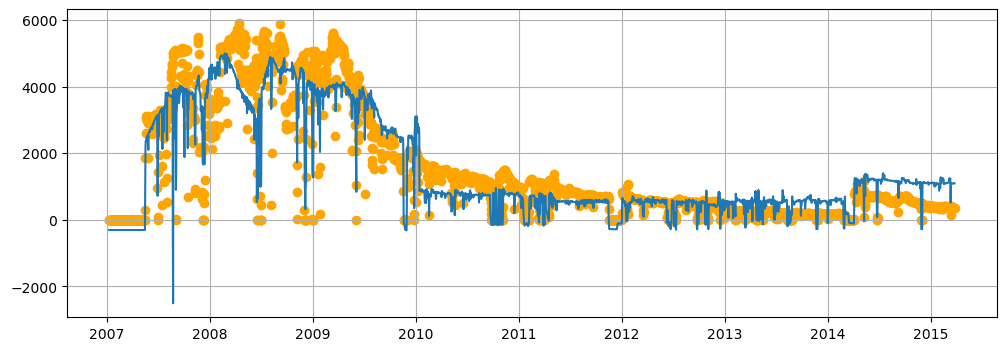

In [37]:
plt.figure(figsize = (12,4))
plt.scatter(df.index[:train_length], y_train, color="orange")
plt.plot(df.index[:train_length], yp_train)
plt.grid()

In [38]:
yp_test = lm.predict(x_test_scaled)

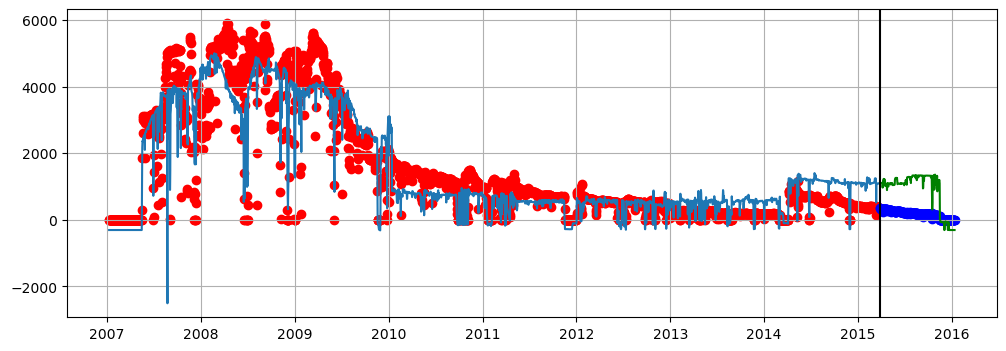

In [41]:
plt.figure(figsize = (12,4))
plt.scatter(df.index[:train_length], y_train, color="red")
plt.plot(df.index[:train_length], yp_train)

plt.scatter(df.index[train_length:], y_test, color="blue") #original oil rate
plt.plot(df.index[train_length:], yp_test, color="green") #predicted oil rate

plt.axvline(df.index[train_length], color="black")

plt.grid()

#this model did not predict well as the original and predicted values were way apart from each other and also some values were negative

In [42]:
#using random forest for better generalizing the model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
yp_train = rf.predict(x_train)
yp_test = rf.predict(x_test)

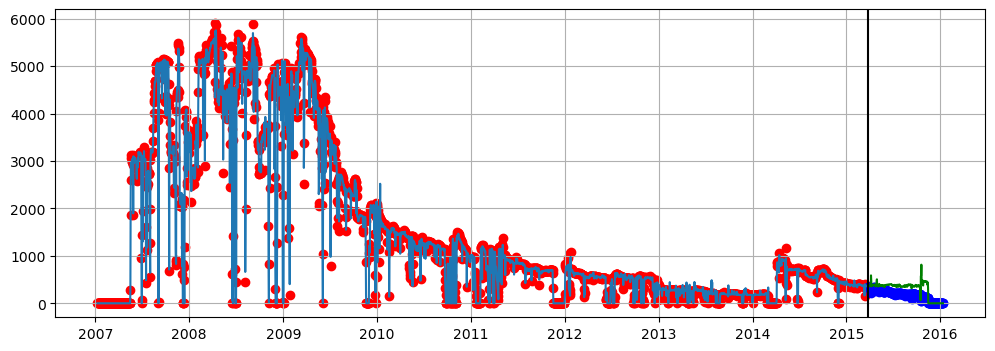

In [43]:
plt.figure(figsize = (12,4))
plt.scatter(df.index[:train_length], y_train, color="red")
plt.plot(df.index[:train_length], yp_train)

plt.scatter(df.index[train_length:], y_test, color="blue") #original oil rate
plt.plot(df.index[train_length:], yp_test, color="green") #predicted oil rate

plt.axvline(df.index[train_length], color="black")

plt.grid()

#this is a better model as this does not need the scaled data and also it predicts the result better than the previous model

In [44]:
rf.feature_importances_

array([0.77098396, 0.05863374, 0.05034729, 0.01221153, 0.01011331,
       0.00419713, 0.04306573, 0.02163172, 0.02881558])